In [1]:
%load_ext autoreload
%autoreload 2

In [134]:
import cv2
import numpy as np
from utils import DataGenerator, preprocess_true_boxes
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import tensorflow as tf
from pprint import pprint

import cv2
import numpy as np
from models import Yolov4, yolov4_head, get_boxes
from config import yolo_config

In [3]:
with open('../dataset/train_txt2/anno.txt') as f:
    lines = f.readlines()

In [4]:
FOLDER_PATH = '..'
anchors = np.array([12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401]).reshape((-1, 2))

In [5]:
lines[0]

'dataset/train_img2/test3.jpg 155,1,493,421,0'

In [244]:
data_gen = DataGenerator(lines[:1], 1, (416, 416), num_classes=80, folder_path=FOLDER_PATH, anchors=anchors)

In [245]:
X, y = data_gen.__getitem__(0)

In [246]:
X.shape, len(y), [y[i].shape for i in range(3)]

((1, 416, 416, 3),
 3,
 [(1, 52, 52, 3, 85), (1, 26, 26, 3, 85), (1, 13, 13, 3, 85)])

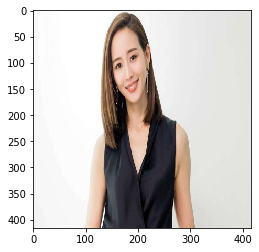

In [247]:
plt.imshow(X[0])

In [248]:
y[0].shape

(1, 52, 52, 3, 85)

In [10]:
# y[0]

In [11]:
# m = 0
# for i in range(len(data_gen)):
#     X, y = data_gen.__getitem__(i)
#     print(y)
#     break
# #     img = X[0].copy()
# #     for b in y[0][0:]:
# #         b = [int(i) for i in b]
# #         cv2.rectangle(img, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 2)
# #     plt.imshow(img)
# #     plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


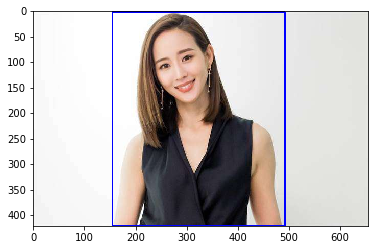

In [249]:
raw = cv2.imread('../dataset/train_img2/test3.jpg')[:,:,::-1]
raw = raw / 255.
cv2.rectangle(raw, (155, 1), (493, 421), (0, 0, 255), 2)
plt.imshow(raw) # (155, 1), (493, 421) 260 177 491 376

In [13]:
# y[0, :10]

In [14]:
# def preprocess_true_boxes(true_boxes, input_shape, anchors, num_classes):
#     '''Preprocess true boxes to training input format

#     Parameters
#     ----------
#     true_boxes: array, shape=(m, T, 5)
#         Absolute x_min, y_min, x_max, y_max, class_id relative to input_shape.
#     input_shape: array-like, hw, multiples of 32
#     anchors: array, shape=(N, 2), wh
#     num_classes: integer

#     Returns
#     -------
#     y_true: list of array, shape like yolo_outputs, xywh are reletive value

#     '''
#     assert (true_boxes[..., 4]<num_classes).all(), 'class id must be less than num_classes'
#     num_layers = len(anchors)//3 # default setting
#     print('num_layers ', num_layers)
#     anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] if num_layers==3 else [[3,4,5], [1,2,3]]

#     true_boxes = np.array(true_boxes, dtype='float32')
#     input_shape = np.array(input_shape, dtype='int32')
#     boxes_xy = (true_boxes[..., 0:2] + true_boxes[..., 2:4]) // 2 #(100, 2) (100, 2)
#     boxes_wh = true_boxes[..., 2:4] - true_boxes[..., 0:2]
#     print('boxes_xy boxes_wh', boxes_xy.shape, boxes_wh.shape)
#     true_boxes[..., 0:2] = boxes_xy/input_shape[::-1]
#     true_boxes[..., 2:4] = boxes_wh/input_shape[::-1]

#     m = true_boxes.shape[0] # bs: 1
#     print('m ', m)
#     grid_shapes = [input_shape//{0:32, 1:16, 2:8}[l] for l in range(num_layers)]
#     y_true = [np.zeros((m,grid_shapes[l][0],grid_shapes[l][1],len(anchor_mask[l]),5+num_classes),
#         dtype='float32') for l in range(num_layers)] # (100, 13, 13, 3, 8) (100, 26, 26, 3, 8) (100, 52, 52, 3, 8)
#     for i in range(3):
#         print(f'y {i}', y_true[i].shape)

#     # Expand dim to apply broadcasting.
#     anchors = np.expand_dims(anchors, 0) # 1, 9 , 2
#     print('anchors ', anchors.shape, anchors) 
#     anchor_maxes = anchors / 2.
#     anchor_mins = -anchor_maxes
#     print(anchor_maxes)
#     valid_mask = boxes_wh[..., 0]>0  # 100,
#     print('valid mask', valid_mask.shape) 

#     for b in range(m):
#         # Discard zero rows.
#         wh = boxes_wh[b, valid_mask[b]]  # (1, 2)
#         print('wh', wh.shape)
#         if len(wh)==0: continue
#         # Expand dim to apply broadcasting.
#         wh = np.expand_dims(wh, -2) # (1, 1, 2)
#         print('wh', wh.shape)
# #         print(wh) # 76. 102
#         box_maxes = wh / 2. # (1, 1, 2)
#         box_mins = -box_maxes # (1, 1, 2)
# #         print(box_maxes, box_mins) # [[[38. 51.]]] [[[-38. -51.]]]
#         print('box_mins, anchor_mins', box_mins.shape, anchor_mins.shape)
#         intersect_mins = np.maximum(box_mins, anchor_mins)
#         intersect_maxes = np.minimum(box_maxes, anchor_maxes)
#         print('intersect_mins', intersect_mins.shape)
# #         print('intersect_mins', 'intersect_max', intersect_mins, intersect_maxes)
#         intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
# #         print(intersect_wh)
#         intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1] # (9,)
#         print('intersect_area ', intersect_area)
# #         print(intersect_area)
#         box_area = wh[..., 0] * wh[..., 1]
#         print('box_area ', box_area.shape)
#         anchor_area = anchors[..., 0] * anchors[..., 1] # 1, 9
#         print('anchor_area', anchor_area.shape)
#         iou = intersect_area / (box_area + anchor_area - intersect_area)
#         print('iou', iou.shape)

#         # Find best anchor for each true box
#         best_anchor = np.argmax(iou, axis=-1)
#         print('best_anchor', best_anchor, best_anchor.shape)
#         print('true_boxes ', true_boxes.shape)
#         for t, n in enumerate(best_anchor): # t: idx, n:anchor idx
#             for l in range(num_layers): # 3
#                 if n in anchor_mask[l]:
#                     print('true_boxes[b,t,0]', true_boxes[b,t,0], b, t, 'grid_shapes[l]', grid_shapes[l])
#                     i = np.floor(true_boxes[b,t,0]*grid_shapes[l][1]).astype('int32') # grid index
#                     j = np.floor(true_boxes[b,t,1]*grid_shapes[l][0]).astype('int32') # grid index 
#                     print(i, j)
#                     k = anchor_mask[l].index(n)
#                     c = true_boxes[b,t, 4].astype('int32')
#                     y_true[l][b, j, i, k, 0:4] = true_boxes[b,t, 0:4] # bbox
#                     y_true[l][b, j, i, k, 4] = 1 # confidence
#                     y_true[l][b, j, i, k, 5+c] = 1 # one hot

#     return y_true

In [15]:

# a = preprocess_true_boxes(y[:1], (416, 416), anchors, num_classes=3)

In [16]:
# len(a)
# a[0].shape, a[1].shape, a[2].shape

In [17]:
# yolo_config

In [15]:
model = Yolov4(
                weight_path=None,
#                 class_name_path='bccd_classes.txt'
#               weight_path='yolov4.weights',

#                img_size=(416, 416, 3),
            
              )
# model.build_model(load_pretrained=False)
model.load_model('test.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


img shape:  (421, 656, 3)
# of bboxes: 1


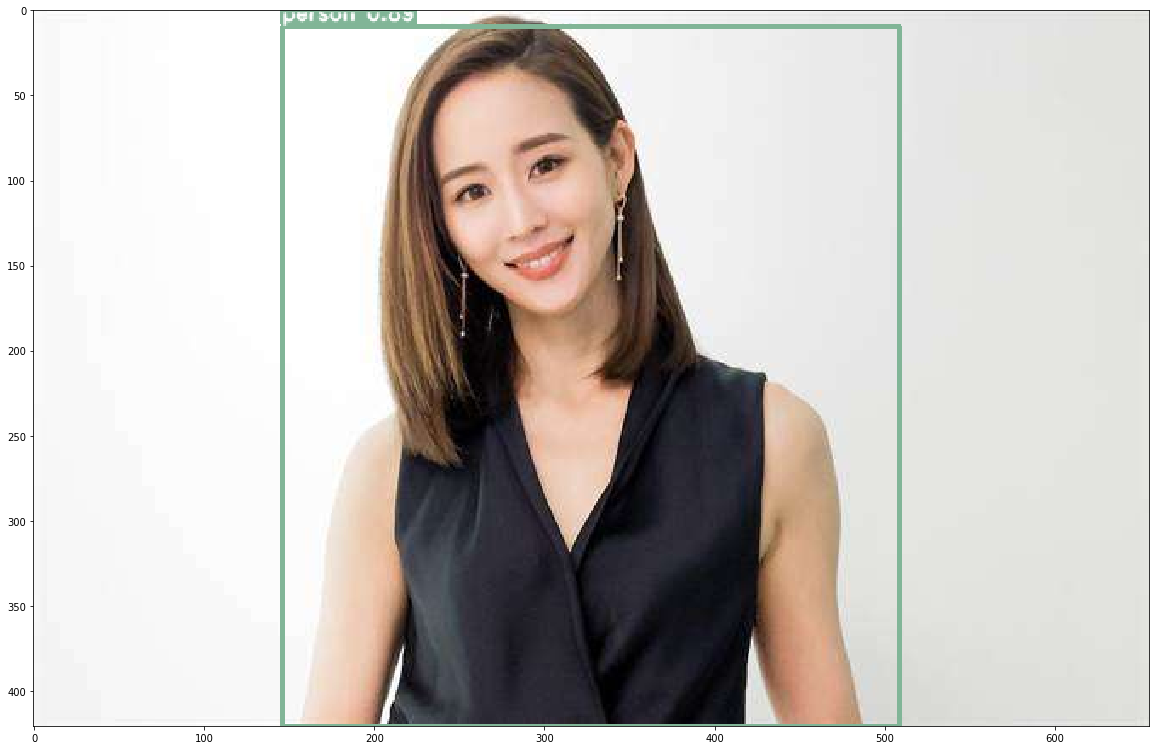

,x1,y1,x2,y2,class_name,score,w,h
0,146,10,509,421,person,0.892524,363,411


In [250]:
model.predict('../dataset/train_img2/test3.jpg')

In [19]:
# qqqwwwee keras v3 loss
# def yolo_loss(y_pred, y_true, anchors, num_classes, ignore_thresh=.5, print_loss=False):
#     '''Return yolo_loss tensor

#     Parameters
#     ----------
#     yolo_outputs: list of tensor, the output of yolo_body or tiny_yolo_body
#     y_true: list of array, the output of preprocess_true_boxes
#     anchors: array, shape=(N, 2), wh
#     num_classes: integer
#     ignore_thresh: float, the iou threshold whether to ignore object confidence loss

#     Returns
#     -------
#     loss: tensor, shape=(1,)

#     '''
# #     num_layers = len(anchors)//3 # default setting
#     num_layers = 3
#     xyscale = [1.2, 1.1, 1.05]
# #     yolo_outputs = args[:num_layers]
#     yolo_outputs = y_pred
# #     y_true = args[num_layers:]
# #     y_true 
# #     anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] if num_layers==3 else [[3,4,5], [1,2,3]]
#     anchor_mask = [[0,1,2], [3,4,5], [6,7,8]]
#     input_shape = K.cast(K.shape(yolo_outputs[0])[1:3] * 32, K.dtype(y_true[0]))
#     grid_shapes = [K.cast(K.shape(yolo_outputs[l])[1:3], K.dtype(y_true[0])) for l in range(num_layers)]
#     # (1, 52, 52, 3, 8), (1, 26, 26, 3, 8), (1, 13, 13, 3, 8)
#     # -> (52, 52), (26, 26) (13, 13)
#     loss = 0
#     m = K.shape(yolo_outputs[0])[0] # batch size, tensor
#     mf = K.cast(m, tf.float32)
# #     mf = K.cast(m, K.dtype(yolo_outputs[0]))

#     for l in range(num_layers):
#         object_mask = y_true[l][..., 4:5]
#         true_class_probs = y_true[l][..., 5:]
#         # grid = [[gridx gridy index]]
# #         grid, raw_pred, pred_xy, pred_wh = yolo_head(yolo_outputs[l],
# #              anchors[anchor_mask[l]], num_classes, input_shape, calc_loss=True)
#         bbox0, object_probability0, class_probabilities0, pred_box0 = get_boxes(yolo_outputs[l],
#                                                                             anchors=anchors[0, :, :], classes=num_classes,
#                                                                             grid_size=52, strides=8,
#                                                                             xyscale=xyscale[0])
# #         pred_box = K.concatenate([pred_xy, pred_wh])
#         pred_box = pred_box0
        

#         # Darknet raw box to calculate loss.
#         # y_true_xy (0~1)
#         print('y_true[l][..., :2] ', y_true[l][..., :2], y_true[l][..., :2].shape)
#         print('grid_shapes[l][::-1] ', grid_shapes[l][::-1], grid_shapes[l][::-1].shape)
# #         print('grid ', grid.shape)
#         raw_true_xy = y_true[l][..., :2]*grid_shapes[l][::-1] - grid # raw_true_xy: xy positiion in grid (0~1)
#         raw_true_wh = K.log(y_true[l][..., 2:4] / anchors[anchor_mask[l]] * input_shape[::-1])
#         raw_true_wh = K.switch(object_mask, raw_true_wh, K.zeros_like(raw_true_wh)) # avoid log(0)=-inf
#         box_loss_scale = 2 - y_true[l][...,2:3]*y_true[l][...,3:4]

#         # Find ignore mask, iterate over each of batch.
#         ignore_mask = tf.TensorArray(K.dtype(y_true[0]), size=1, dynamic_size=True)
#         object_mask_bool = K.cast(object_mask, 'bool')
#         def loop_body(b, ignore_mask):
#             true_box = tf.boolean_mask(y_true[l][b,...,0:4], object_mask_bool[b,...,0])
#             iou = box_iou(pred_box[b], true_box)
#             best_iou = K.max(iou, axis=-1)
#             ignore_mask = ignore_mask.write(b, K.cast(best_iou<ignore_thresh, K.dtype(true_box)))
#             return b+1, ignore_mask
# #        _, ignore_mask = K.control_flow_ops.while_loop(lambda b,*args: b<m, loop_body, [0, ignore_mask])
#         _, ignore_mask = control_flow_ops.while_loop(lambda b,*args: b<m, loop_body, [0, ignore_mask])
#         ignore_mask = ignore_mask.stack()
#         ignore_mask = K.expand_dims(ignore_mask, -1)

#         # K.binary_crossentropy is helpful to avoid exp overflow.
#         xy_loss = object_mask * box_loss_scale * K.binary_crossentropy(raw_true_xy, raw_pred[...,0:2], from_logits=True)
#         wh_loss = object_mask * box_loss_scale * 0.5 * K.square(raw_true_wh-raw_pred[...,2:4])
#         confidence_loss = object_mask * K.binary_crossentropy(object_mask, raw_pred[...,4:5], from_logits=True)+ \
#             (1-object_mask) * K.binary_crossentropy(object_mask, raw_pred[...,4:5], from_logits=True) * ignore_mask
#         class_loss = object_mask * K.binary_crossentropy(true_class_probs, raw_pred[...,5:], from_logits=True)

#         xy_loss = K.sum(xy_loss) / mf
#         wh_loss = K.sum(wh_loss) / mf
#         confidence_loss = K.sum(confidence_loss) / mf
#         class_loss = K.sum(class_loss) / mf
#         loss += xy_loss + wh_loss + confidence_loss + class_loss
#         if print_loss:
#             loss = tf.Print(loss, [loss, xy_loss, wh_loss, confidence_loss, class_loss, K.sum(ignore_mask)], message='loss: ')
#     return loss

In [20]:
# def broadcast_iou(box_1, box_2):
#     box_1 = tf.expand_dims(box_1, -2)
#     box_2 = tf.expand_dims(box_2, 0)
#     new_shape = tf.broadcast_dynamic_shape(tf.shape(box_1), tf.shape(box_2))
#     box_1 = tf.broadcast_to(box_1, new_shape)
#     box_2 = tf.broadcast_to(box_2, new_shape)
#     int_w = tf.maximum(
#         tf.minimum(box_1[..., 2], box_2[..., 2])
#         - tf.maximum(box_1[..., 0], box_2[..., 0]),
#         0,
#     )
#     int_h = tf.maximum(
#         tf.minimum(box_1[..., 3], box_2[..., 3])
#         - tf.maximum(box_1[..., 1], box_2[..., 1]),
#         0,
#     )
#     int_area = int_w * int_h
#     box_1_area = (box_1[..., 2] - box_1[..., 0]) * (
#         box_1[..., 3] - box_1[..., 1]
#     )
#     box_2_area = (box_2[..., 2] - box_2[..., 0]) * (
#         box_2[..., 3] - box_2[..., 1]
#     )
#     return int_area / (box_1_area + box_2_area - int_area)

# def yolo_loss(y_true, y_pred, num_classes, anchors, xyscale=[1.2, 1.1, 1.05], ignore_thresh=0.5):
# #     get_boxes(yolo_neck_outputs[0],
# #             anchors=anchors[0, :, :], classes=80,
# #             grid_size=52, strides=8,
# #             xyscale=xyscale[0])
#     yolo_outputs = tf.cast(y_pred[0], tf.float32)
#     y_true = y_true[0]
#     anchors = anchors[0]
#     print('yolo_outputs ', yolo_outputs.shape, 'y_true', y_true.shape)
#     pred_box_x1y1x2y2, object_probability0, class_probabilities0, pred_box_wywh = get_boxes(yolo_outputs,
#                                                                     anchors=anchors, classes=num_classes,
#                                                                     grid_size=52, strides=8,
#                                                                     xyscale=xyscale[0])
# #     pred_box, pred_obj, pred_class, pred_xywh = get_boxes(
# #         y_pred, anchors, classes
# #     )
#     pred_box = pred_box_x1y1x2y2
#     pred_obj = object_probability0
#     pred_class = class_probabilities0
#     pred_xywh = pred_box_xywh
#     pred_xy = pred_xywh[..., 0:2]
#     pred_wh = pred_xywh[..., 2:4]
# #     true_box, true_obj, true_class_idx = tf.split(
# #         y_true, (4, 1, 1), axis=-1
# #     )
#     true_box = y_true[..., :4]
#     true_obj = y_true[..., 4]
#     true_classes = y_true[..., 5:]
#     print('true_classes ', true_classes.shape)
# #     true_class_idx
# #     true_xy = (true_box[..., 0:2] + true_box[..., 2:4]) / 2
# #     true_wh = true_box[..., 2:4] - true_box[..., 0:2]
#     true_xy = true_box[..., :2]
#     true_wh = true_box[..., 2:4]
    
#     box_loss_scale = 2 - true_wh[..., 0] * true_wh[..., 1]
#     grid_size = tf.shape(y_true)[1]
#     grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
#     grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
#     true_xy = true_xy * tf.cast(grid_size, tf.float32) - tf.cast(
#         grid, tf.float32
#     )
# #     true_wh  (1, 52, 52, 3, 2)
# #     anchors  (3, 2)
#     true_wh = tf.math.log(true_wh / anchors)
#     true_wh = tf.where(
#         tf.math.is_inf(true_wh), tf.zeros_like(true_wh), true_wh
#     )
#     true_wh = tf.cast(true_wh, tf.float32)
# #     true obj  (1, 52, 52, 3)
# #     obj_mask = tf.squeeze(true_obj, -1)
#     obj_mask = true_obj
#     print('pred_box, true_box, obj_mask', pred_box.shape, true_box.shape, obj_mask.shape)
#     # pred_box, true_box, obj_mask (1, 52, 52, 3, 4) (1, 52, 52, 3, 4) (1, 52, 52, 3)
#     best_iou = tf.map_fn(
#         lambda x: tf.reduce_max(
#             broadcast_iou(
#                 x[0], tf.boolean_mask(x[1], tf.cast(x[2], tf.bool))
#             ),
#             axis=-1,
#         ),
#         (pred_box, true_box, obj_mask),
#         tf.float32,
#     )
#     ignore_mask = tf.cast(best_iou < ignore_thresh, tf.float32)
#     xy_loss = (
#         obj_mask
#         * box_loss_scale
#         * tf.reduce_sum(tf.square(true_xy - pred_xy), axis=-1)
#     )
#     wh_loss = (
#         obj_mask
#         * box_loss_scale
#         * tf.reduce_sum(tf.square(true_wh - pred_wh), axis=-1)
#     )
#     print('true_obj pred_obj', true_obj.shape, pred_obj.shape)
#     # true_obj pred_obj (1, 52, 52, 3) (1, 52, 52, 3, 1)
#     obj_loss = tf.keras.losses.binary_crossentropy(tf.expand_dims(true_obj, -1), pred_obj)
#     print('obj_mask, obj_loss, ignore_mask', obj_mask.shape, obj_loss.shape, ignore_mask.shape)
#     # obj_mask, obj_loss, ignore_mask (1, 52, 52, 3) (1, 52, 52, 3) (1, 52, 52, 3)
#     obj_loss = (
#         obj_mask * obj_loss + (1 - obj_mask) * ignore_mask * obj_loss
#     )
#     print('pred_class ', pred_class.shape)
#     class_loss = obj_mask * tf.keras.losses.categorical_crossentropy(
#         true_classes, pred_class
#     )
#     xy_loss = tf.reduce_sum(xy_loss, axis=(1, 2, 3))
#     wh_loss = tf.reduce_sum(wh_loss, axis=(1, 2, 3))
#     obj_loss = tf.reduce_sum(obj_loss, axis=(1, 2, 3))
#     class_loss = tf.reduce_sum(class_loss, axis=(1, 2, 3))
#     return xy_loss + wh_loss + obj_loss + class_loss

In [29]:
# from tflite yolov4
def bbox_giou(bboxes1, bboxes2):
    """
    Generalized IoU
    @param bboxes1: (a, b, ..., 4)
    @param bboxes2: (A, B, ..., 4)
        x:X is 1:n or n:n or n:1
    @return (max(a,A), max(b,B), ...)
    ex) (4,):(3,4) -> (3,)
        (2,1,4):(2,3,4) -> (2,3)
    """
    bboxes1_area = bboxes1[..., 2] * bboxes1[..., 3]
    bboxes2_area = bboxes2[..., 2] * bboxes2[..., 3]

    bboxes1_coor = tf.concat(
        [
            bboxes1[..., :2] - bboxes1[..., 2:] * 0.5,
            bboxes1[..., :2] + bboxes1[..., 2:] * 0.5,
        ],
        axis=-1,
    )
    bboxes2_coor = tf.concat(
        [
            bboxes2[..., :2] - bboxes2[..., 2:] * 0.5,
            bboxes2[..., :2] + bboxes2[..., 2:] * 0.5,
        ],
        axis=-1,
    )

    left_up = tf.maximum(bboxes1_coor[..., :2], bboxes2_coor[..., :2])
    right_down = tf.minimum(bboxes1_coor[..., 2:], bboxes2_coor[..., 2:])

    inter_section = tf.maximum(right_down - left_up, 0.0)
    inter_area = inter_section[..., 0] * inter_section[..., 1]

    union_area = bboxes1_area + bboxes2_area - inter_area

    iou = tf.math.divide_no_nan(inter_area, union_area)

    enclose_left_up = tf.minimum(bboxes1_coor[..., :2], bboxes2_coor[..., :2])
    enclose_right_down = tf.maximum(
        bboxes1_coor[..., 2:], bboxes2_coor[..., 2:]
    )

    enclose_section = enclose_right_down - enclose_left_up
    enclose_area = enclose_section[..., 0] * enclose_section[..., 1]

    giou = iou - tf.math.divide_no_nan(enclose_area - union_area, enclose_area)

    return giou
def bbox_iou(bboxes1, bboxes2):
    """
    @param bboxes1: (a, b, ..., 4)
    @param bboxes2: (A, B, ..., 4)
        x:X is 1:n or n:n or n:1
    @return (max(a,A), max(b,B), ...)
    ex) (4,):(3,4) -> (3,)
        (2,1,4):(2,3,4) -> (2,3)
    """
    bboxes1_area = bboxes1[..., 2] * bboxes1[..., 3]
    bboxes2_area = bboxes2[..., 2] * bboxes2[..., 3]

    bboxes1_coor = tf.concat(
        [
            bboxes1[..., :2] - bboxes1[..., 2:] * 0.5,
            bboxes1[..., :2] + bboxes1[..., 2:] * 0.5,
        ],
        axis=-1,
    )
    bboxes2_coor = tf.concat(
        [
            bboxes2[..., :2] - bboxes2[..., 2:] * 0.5,
            bboxes2[..., :2] + bboxes2[..., 2:] * 0.5,
        ],
        axis=-1,
    )

    left_up = tf.maximum(bboxes1_coor[..., :2], bboxes2_coor[..., :2])
    right_down = tf.minimum(bboxes1_coor[..., 2:], bboxes2_coor[..., 2:])

    inter_section = tf.maximum(right_down - left_up, 0.0)
    inter_area = inter_section[..., 0] * inter_section[..., 1]

    union_area = bboxes1_area + bboxes2_area - inter_area

    iou = tf.math.divide_no_nan(inter_area, union_area)

    return iou
def yolo_loss_wrapper(input_shape, STRIDES, NUM_CLASS, ANCHORS, XYSCALES, IOU_LOSS_THRESH):
    input_shape = input_shape[0]
    def yolo_loss(y_true, y_pred):
#         num_stages = 3 # len(y_true)
#         input_shape = input_shape[0]
        # conv_shape = tf.shape(conv)
        bboxes_tensor = decode_train2(y_pred, input_shape // STRIDES, NUM_CLASS, STRIDES, ANCHORS, XYSCALES)
        raw_convs = y_pred

        total_loss = 0
#         for stage in range(num_stages):
        label = y_true
        bboxes = bboxes_tensor
        batch_size = tf.shape(label)[0]
        grid_size = tf.shape(label)[1]
        output_size = grid_size
        input_size = STRIDES * output_size
        conv = raw_convs
        # pred = conv
        # pred = tf.sigmoid(pred)

        conv = tf.reshape(conv, (batch_size, output_size, output_size, 3, 5 + NUM_CLASS))
        # conv_raw_conf = conv[:, :, :, :, 4:5]
        # conv_raw_prob = conv[:, :, :, :, 5:]
        conv_raw_conf = bboxes[..., 4:5]
        conv_raw_prob = bboxes[..., 5:]

        pred_xywh = bboxes[:, :, :, :, 0:4]  # abs xy wh
        pred_conf = bboxes[:, :, :, :, 4:5]
        # pred_xywh = pred[:, :, :, :, 0:4]  # abs xy wh
        # pred_conf = pred[:, :, :, :, 4:5]

        label_xywh = label[:, :, :, :, 0:4]
        respond_bbox = label[:, :, :, :, 4:5]
        label_prob = label[:, :, :, :, 5:]

        giou = tf.expand_dims(bbox_giou(pred_xywh, label_xywh), axis=-1)
        input_size = tf.cast(input_size, tf.float32)

        bbox_loss_scale = 2.0 - 1.0 * label_xywh[:, :, :, :, 2:3] * label_xywh[:, :, :, :, 3:4] / (input_size ** 2)
        giou_loss = respond_bbox * bbox_loss_scale * (1 - giou)

        # iou = utils.bbox_iou(pred_xywh[:, :, :, :, np.newaxis, :], bboxes[:, np.newaxis, np.newaxis, np.newaxis, :, :])
        #
        # iou = bbox_iou(pred_xywh, bboxes)
        iou = bbox_iou(pred_xywh, label_xywh)

        # max_iou = tf.expand_dims(tf.reduce_max(iou, axis=-1), axis=-1)
        max_iou = tf.reduce_max(iou, axis=-1)[..., tf.newaxis, tf.newaxis]
        respond_bgd = (1.0 - respond_bbox) * tf.cast(max_iou < IOU_LOSS_THRESH, tf.float32)

        conf_focal = tf.pow(respond_bbox - pred_conf, 2)

        conf_loss = conf_focal * (
                respond_bbox * tf.nn.sigmoid_cross_entropy_with_logits(labels=respond_bbox, logits=conv_raw_conf)
                +
                respond_bgd * tf.nn.sigmoid_cross_entropy_with_logits(labels=respond_bbox, logits=conv_raw_conf)
        )

        prob_loss = respond_bbox * tf.nn.sigmoid_cross_entropy_with_logits(labels=label_prob, logits=conv_raw_prob)

        giou_loss = tf.reduce_mean(tf.reduce_sum(giou_loss, axis=[1, 2, 3, 4]))
        conf_loss = tf.reduce_mean(tf.reduce_sum(conf_loss, axis=[1, 2, 3, 4]))
        prob_loss = tf.reduce_mean(tf.reduce_sum(prob_loss, axis=[1, 2, 3, 4]))

        return giou_loss + conf_loss + prob_loss
    return yolo_loss

def decode_train2(conv_output, output_size, NUM_CLASS, STRIDES, ANCHORS, XYSCALE):
    conv_output = tf.reshape(conv_output,
                             (tf.shape(conv_output)[0], output_size, output_size, 3, 5 + NUM_CLASS))

    conv_raw_dxdy, conv_raw_dwdh, conv_raw_conf, conv_raw_prob = tf.split(conv_output, (2, 2, 1, NUM_CLASS),
                                                                          axis=-1)

    xy_grid = tf.meshgrid(tf.range(output_size), tf.range(output_size))
    xy_grid = tf.expand_dims(tf.stack(xy_grid, axis=-1), axis=2)  # [gx, gy, 1, 2]
    xy_grid = tf.tile(tf.expand_dims(xy_grid, axis=0), [tf.shape(conv_output)[0], 1, 1, 3, 1])

    xy_grid = tf.cast(xy_grid, tf.float32)

    pred_xy = ((tf.sigmoid(conv_raw_dxdy) * XYSCALE) - 0.5 * (XYSCALE - 1) + xy_grid) * STRIDES
    pred_wh = (tf.exp(conv_raw_dwdh) * ANCHORS)
    pred_xywh = tf.concat([pred_xy, pred_wh], axis=-1)

    pred_conf = tf.sigmoid(conv_raw_conf)
    pred_prob = tf.sigmoid(conv_raw_prob)

    return tf.concat([pred_xywh, pred_conf, pred_prob], axis=-1)

In [263]:
len(data_gen)

1

In [264]:
x_batch, y_batch = X, y = data_gen.__getitem__(0)

In [265]:
x_batch.shape, [y_batch[i].shape for i in range(3) ]

((1, 416, 416, 3),
 [(1, 52, 52, 3, 85), (1, 26, 26, 3, 85), (1, 13, 13, 3, 85)])

In [266]:
y_pred = model.yolo_model.predict(x_batch)
y_pred[0], y_pred[0].shape, y_pred[1].shape, y_pred[2].shape

(array([[[[ 1.92684323e-01,  4.70553339e-03, -3.25091064e-01, ...,
           -7.48140192e+00, -7.33025074e+00, -7.60484362e+00],
          [ 3.59633535e-01,  9.13126767e-02,  7.17952967e-01, ...,
           -7.92454815e+00, -7.53366756e+00, -8.67181492e+00],
          [-4.70207512e-01, -3.26502740e-01,  1.07563639e+00, ...,
           -7.31230688e+00, -6.89751053e+00, -8.53446293e+00],
          ...,
          [-6.78797424e-01, -1.48754969e-01,  1.41953123e+00, ...,
           -7.05732584e+00, -5.15669870e+00, -5.36032724e+00],
          [ 1.47106245e-01,  1.78823709e-01,  6.92542076e-01, ...,
           -6.79594231e+00, -5.60554981e+00, -3.55692625e+00],
          [-1.05126508e-01,  2.54495710e-01, -5.65513372e-02, ...,
           -5.98874664e+00, -5.99938583e+00, -3.46918869e+00]],
 
         [[-1.14882156e-01,  1.22810304e-01, -5.33798993e-01, ...,
           -7.98593187e+00, -7.31593752e+00, -7.97113085e+00],
          [ 1.22921050e-01, -2.57019401e-01,  6.71055496e-01, ...,
     

In [267]:
pred_large = np.reshape(y_pred[2], (1, 13,13,3,85))
pred_large[0].shape
pred_large[0, 6,6,:,4]

array([-3.6373584,  2.7128265,  2.8486443], dtype=float32)

In [268]:
pred_large[0, 6,6,1,5:], pred_large[0, 6,6,2,5:]

(array([  7.636606 , -11.252513 , -11.441111 , -12.96235  , -11.584581 ,
        -10.93054  ,  -9.138035 , -11.347572 , -11.335099 , -12.179684 ,
        -13.4807   , -12.16067  , -12.46946  , -11.511032 , -13.44124  ,
        -10.28499  , -12.381161 , -12.594769 , -15.289934 , -14.314249 ,
        -13.6186695, -13.47594  , -14.472248 , -13.561726 , -10.245218 ,
        -10.248945 , -10.158533 , -10.047979 ,  -9.22928  , -13.340868 ,
        -11.557777 , -13.176586 , -12.204084 , -13.422211 , -12.226296 ,
        -13.403009 , -11.704605 , -11.341715 , -12.506599 , -10.170585 ,
        -13.066299 , -12.255553 , -13.978083 , -12.955928 , -13.523987 ,
        -12.741533 , -12.994468 , -12.407428 , -13.290152 , -13.36681  ,
        -14.730848 , -12.739487 , -13.045448 , -13.122875 , -13.226494 ,
        -12.824196 , -11.116887 , -11.433914 , -12.644731 ,  -9.282808 ,
         -8.865642 , -12.049185 ,  -9.141024 , -10.2208185, -11.804696 ,
        -12.14802  , -11.335205 , -10.0374565, -10.

In [259]:
np.max(pred_large[0, :,:,:,4])

2.8486443

In [45]:
np.unravel_index(pred_large[0].argmax(), pred_large[0].shape)

(6, 6, 1, 5)

In [260]:

# pprint(y_batch[2][0, 6, :, :, :4])

In [281]:
def bbox_giou(bboxes1, bboxes2):
    """
    Generalized IoU
    @param bboxes1: (a, b, ..., 4)
    @param bboxes2: (A, B, ..., 4)
        x:X is 1:n or n:n or n:1
    @return (max(a,A), max(b,B), ...)
    ex) (4,):(3,4) -> (3,)
        (2,1,4):(2,3,4) -> (2,3)
    """
    bboxes1_area = bboxes1[..., 2] * bboxes1[..., 3]
    bboxes2_area = bboxes2[..., 2] * bboxes2[..., 3]

    bboxes1_coor = np.concatenate(
        [
            bboxes1[..., :2] - bboxes1[..., 2:] * 0.5,
            bboxes1[..., :2] + bboxes1[..., 2:] * 0.5,
        ],
        axis=-1,
    )
    bboxes2_coor = np.concatenate(
        [
            bboxes2[..., :2] - bboxes2[..., 2:] * 0.5,
            bboxes2[..., :2] + bboxes2[..., 2:] * 0.5,
        ],
        axis=-1,
    )

    left_up = np.maximum(bboxes1_coor[..., :2], bboxes2_coor[..., :2])
    right_down = np.minimum(bboxes1_coor[..., 2:], bboxes2_coor[..., 2:])

    inter_section = np.maximum(right_down - left_up, 0.0)
    inter_area = inter_section[..., 0] * inter_section[..., 1]

    union_area = bboxes1_area + bboxes2_area - inter_area

    iou = np.nan_to_num(inter_area/union_area)

    enclose_left_up = np.minimum(bboxes1_coor[..., :2], bboxes2_coor[..., :2])
    enclose_right_down = np.maximum(
        bboxes1_coor[..., 2:], bboxes2_coor[..., 2:]
    )

    enclose_section = enclose_right_down - enclose_left_up
    enclose_area = enclose_section[..., 0] * enclose_section[..., 1]

    giou = iou - np.nan_to_num((enclose_area - union_area)/enclose_area)
    return giou
# xywh
def bbox_iou(boxes1, boxes2):

    boxes1_area = boxes1[..., 2] * boxes1[..., 3]
    boxes2_area = boxes2[..., 2] * boxes2[..., 3]

    boxes1_coor = np.concatenate([boxes1[..., :2] - boxes1[..., 2:] * 0.5,
                             boxes1[..., :2] + boxes1[..., 2:] * 0.5], axis=-1)
    boxes2_coor = np.concatenate([boxes2[..., :2] - boxes2[..., 2:] * 0.5,
                             boxes2[..., :2] + boxes2[..., 2:] * 0.5], axis=-1)

    left_up    = np.maximum(boxes1_coor[..., :2], boxes2_coor[..., :2])
    right_down = np.minimum(boxes1_coor[..., 2:], boxes2_coor[..., 2:])
    
    inter_section = np.maximum(right_down - left_up, 0.0)

    inter_area = inter_section[..., 0] * inter_section[..., 1]

    union_area = boxes1_area + boxes2_area - inter_area
    iou       = np.maximum(1.0 * inter_area / union_area, np.finfo(np.float32).eps)

    return iou
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def decode_train2(conv_output, output_size, NUM_CLASS, STRIDES, ANCHORS, XYSCALE):
#     conv_output = tf.reshape(conv_output,
#                              (tf.shape(conv_output)[0], output_size, output_size, 3, 5 + NUM_CLASS))
    conv_output = np.reshape(conv_output,
                             (conv_output.shape[0], output_size, output_size, 3, 5 + NUM_CLASS))
#     conv_raw_dxdy, conv_raw_dwdh, conv_raw_conf, conv_raw_prob = tf.split(conv_output, (2, 2, 1, NUM_CLASS),
#                                                                           axis=-1)
    conv_raw_dxdy, conv_raw_dwdh, conv_raw_conf, conv_raw_prob = np.split(conv_output, [2, 4, 5],
                                                                      axis=-1)


#     xy_grid = tf.meshgrid(tf.range(output_size), tf.range(output_size))
    xy_grid = np.meshgrid(range(output_size), range(output_size))
    xy_grid = np.expand_dims(np.stack(xy_grid, axis=-1), axis=2)  # [gx, gy, 1, 2]
    xy_grid = np.tile(np.expand_dims(xy_grid, axis=0), [conv_output.shape[0], 1, 1, 3, 1])
    xy_grid = xy_grid.astype(np.float32)
#     print(xy_grid.dtype, )

    pred_xy = ((sigmoid(conv_raw_dxdy) * XYSCALE) - 0.5 * (XYSCALE - 1) + xy_grid) * STRIDES
    
    pred_wh = (np.exp(conv_raw_dwdh) * ANCHORS)

    pred_xywh = np.concatenate([pred_xy, pred_wh], axis=-1)

    pred_conf = sigmoid(conv_raw_conf)

    pred_prob = sigmoid(conv_raw_prob)


    return np.concatenate([pred_xywh, pred_conf, pred_prob], axis=-1)

In [277]:
bboxes_pred = decode_train2(pred_large, 13, NUM_CLASS=80, STRIDES=32, ANCHORS=anchors.reshape(3, 3, 2)[2], 
              XYSCALE=1.)[:, :, :, :, :4]

bboxes_true = y_batch[2][:, :, :, :, :4]

bboxes_tensor.shape, bboxes_pred.shape
# print(bboxes_true, '\n', '\n', bboxes_pred)
# bbox_iou(bboxes_true, bboxes_pred)

((3, 4), (1, 13, 13, 3, 4))

In [ ]:
# decode_train2(y_pred, 13, NUM_CLASS=NUM_CLASS, STRIDES=STRIDES, ANCHORS=anchors.reshape(3, 3, 2)[2], 
#               XYSCALE=1.)

In [374]:
def yolo_loss(y_true, y_pred):
    IOU_LOSS_THRESH=0.5
    STRIDES = 32
    bboxes_tensor = decode_train2(y_pred, 13, NUM_CLASS=80, STRIDES=STRIDES, ANCHORS=anchors.reshape(3, 3, 2)[2], 
              XYSCALE=1.)

    label = y_true
    bboxes = bboxes_tensor
    grid_size = tf.shape(label)[1]
    output_size = grid_size
    input_size = STRIDES * output_size

    conv_raw_conf = bboxes[..., 4:5]
    conv_raw_prob = bboxes[..., 5:]

    pred_xywh = bboxes[:, :, :, :, 0:4]  # abs xy wh
    pred_conf = bboxes[:, :, :, :, 4:5]

    label_xywh = label[:, :, :, :, 0:4]
    respond_bbox = label[:, :, :, :, 4:5]
    label_prob = label[:, :, :, :, 5:]

    giou = tf.expand_dims(bbox_giou(pred_xywh, label_xywh), axis=-1)
    input_size = tf.cast(input_size, tf.float64)

    bbox_loss_scale = 2.0 - 1.0 * label_xywh[:, :, :, :, 2:3] * label_xywh[:, :, :, :, 3:4] / (input_size ** 2)
    giou_loss = tf.cast(respond_bbox, tf.float64) * tf.cast(bbox_loss_scale, tf.float64) * tf.cast((1. - giou), tf.float64)

    # iou = utils.bbox_iou(pred_xywh[:, :, :, :, np.newaxis, :], bboxes[:, np.newaxis, np.newaxis, np.newaxis, :, :])
    #
    # iou = bbox_iou(pred_xywh, bboxes)
    iou = bbox_iou(pred_xywh, label_xywh)

    # max_iou = tf.expand_dims(tf.reduce_max(iou, axis=-1), axis=-1)
    max_iou = tf.reduce_max(iou, axis=-1)[..., tf.newaxis, tf.newaxis]
    respond_bgd = tf.cast((1.0 - respond_bbox) * tf.cast(max_iou < IOU_LOSS_THRESH, tf.float64), tf.float64)

    conf_focal = tf.pow(respond_bbox - pred_conf, 2)

    conf_loss = conf_focal * (
            respond_bbox * tf.expand_dims(tf.keras.losses.binary_crossentropy(respond_bbox, pred_conf), axis=-1)  # tf.nn.sigmoid_cross_entropy_with_logits(labels=respond_bbox, logits=conv_raw_conf)
            +
            respond_bgd * tf.expand_dims(tf.keras.losses.binary_crossentropy(respond_bbox, pred_conf), axis=-1)  #  tf.nn.sigmoid_cross_entropy_with_logits(labels=respond_bbox, logits=conv_raw_conf)
    )

    prob_loss = respond_bbox * tf.expand_dims(tf.keras.losses.categorical_crossentropy(label_prob, tf.nn.softmax(conv_raw_prob)), axis=-1)  #  tf.nn.sigmoid_cross_entropy_with_logits(labels=label_prob, logits=conv_raw_prob)

    giou_loss = tf.reduce_mean(tf.reduce_sum(giou_loss, axis=[1, 2, 3, 4]))
    conf_loss = tf.reduce_mean(tf.reduce_sum(conf_loss, axis=[1, 2, 3, 4]))
    prob_loss = tf.reduce_mean(tf.reduce_sum(prob_loss, axis=[1, 2, 3, 4]))

    return [giou_loss, conf_loss, prob_loss]

In [377]:
[i.numpy() for i in yolo_loss(y_batch[2], y_batch[2])]
# yolo_loss(y_batch[2], pred_large)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in subtract


AttributeError: 'Tensor' object has no attribute 'numpy'

In [26]:
# loss = yolo_loss_wrapper(input_shape=(416, 416), 
#                   STRIDES=[8, 16, 32], 
#                   NUM_CLASS=3, 
#                   ANCHORS=anchors.reshape(3, 3, 2), 
#                   XYSCALES=[1., 1., 1.], 
#                   IOU_LOSS_THRESH=0.5)

In [30]:
losses = [yolo_loss_wrapper(input_shape=(416, 416), 
                  STRIDES=[8, 16, 32][i], 
                  NUM_CLASS=3, 
                  ANCHORS=anchors.reshape(3, 3, 2)[i], 
                  XYSCALES=[1., 1., 1.][i], 
                  IOU_LOSS_THRESH=0.5) for i in range(3)]

In [31]:
model.yolo_model.compile(tf.keras.optimizers.Adam(), 
                         loss= {'conv2d_93': losses[0],  # [93, 101, 109]
                                'conv2d_101': losses[1],
                                'conv2d_109': losses[2]})

ValueError: Index out of range using input dim 4; input has only 4 dims for 'loss_1/conv2d_93_loss/strided_slice_8' (op: 'StridedSlice') with input shapes: [?,?,?,?], [5], [5], [5] and with computed input tensors: input[3] = <1 1 1 1 1>.